<a href="https://colab.research.google.com/github/jair31jm/CodigosIA/blob/main/Ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Descarga del Conjunto de Datos de Membranas Celulares:

Los estudiantes deberán descargar las imágenes ruidosas de membranas celulares desde el siguiente enlace: https://zenodo.org/record/5156991/files/Flywing_n0.zip?download=1
2. Cargar y Visualizar Imágenes de Membranas Celulares:

Las imágenes se cargarán desde el archivo train_data.npz. El archivo contiene imágenes ruidosas en data['X_train']. Los estudiantes visualizarán algunos ejemplos para familiarizarse con los datos. Visualizar al menos 10 imágenes seleccionadas aleatoriamente.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Claves disponibles en el archivo: ['X_train', 'Y_train', 'X_val', 'Y_val']
Dimensiones del conjunto: (1428, 128, 128)


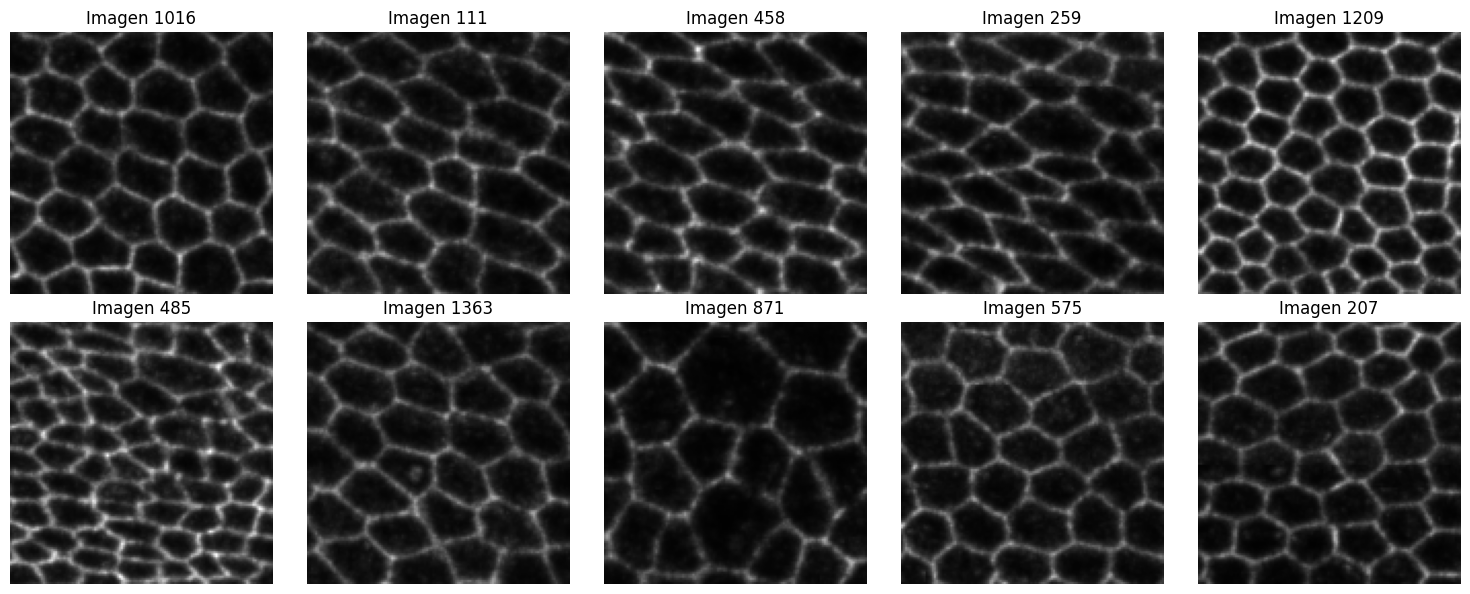

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Ruta al archivo .npz
ruta_npz = "/content/drive/MyDrive/Master IA - Notebooks/Flywing_n0/train/train_data.npz"

# Cargar el archivo
data = np.load(ruta_npz)

# Ver claves disponibles
print("Claves disponibles en el archivo:", data.files)

# Asegúrate de que existe la clave 'X_train' (puede variar)
X_train = data['X_train']  # Cambia si la clave es distinta

# Mostrar tamaño del conjunto
print(f"Dimensiones del conjunto: {X_train.shape}")  # (N, H, W)

# Seleccionar 10 imágenes aleatorias
indices = random.sample(range(X_train.shape[0]), 10)
imagenes = X_train[indices]

# Visualizar las imágenes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(imagenes[i], cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"Imagen {indices[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
if 'Y_train' in data:
    print("Sí, hay imágenes GT en la clave 'Y_train'")
else:
    print("No se encontraron imágenes GT bajo 'Y_train'")


Sí, hay imágenes GT en la clave 'Y_train'


3. Aplicación de Filtros en Dominio Espacial:

Aplicación de filtros pasa bajo y pasa alto a las imagenes de membranas celulares. Se deberán graficar los resultados de las imágenes filtradas y compararlas con las originales para evaluar la eliminación de ruido. Cuando sea posible, usar varios valores de los parámetros hasta encontrar parámetros que den resultados visualmente buenos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# --- Cargar el archivo .npz ---
ruta_npz = "/content/drive/MyDrive/Master IA - Notebooks/Flywing_n0/train/train_data.npz"
data = np.load(ruta_npz)

# --- Extraer imágenes y ground truth (GT) ---
imagenes = data['X_train']
GT = (data['Y_train'] < 1).astype(np.uint8)

print("Forma del dataset:", imagenes.shape)

# --- Seleccionar 10 imágenes al azar ---
num_imgs = 10
idxs = random.sample(range(imagenes.shape[0]), num_imgs)

# Guardar en memoria
imagenes_con_ruido = [imagenes[i].squeeze().astype(np.uint8) for i in idxs]
imag_GT= [GT[i].squeeze().astype(np.uint8) * 255 for i in idxs]  # binario a 0-255

# Verificación de forma
print(f"🔢 Total imágenes seleccionadas: {len(imagenes_con_ruido)}")
print(f"✅ Ejemplo shape: {imagenes_con_ruido[0].shape}")



Forma del dataset: (1428, 128, 128)
🔢 Total imágenes seleccionadas: 10
✅ Ejemplo shape: (128, 128)


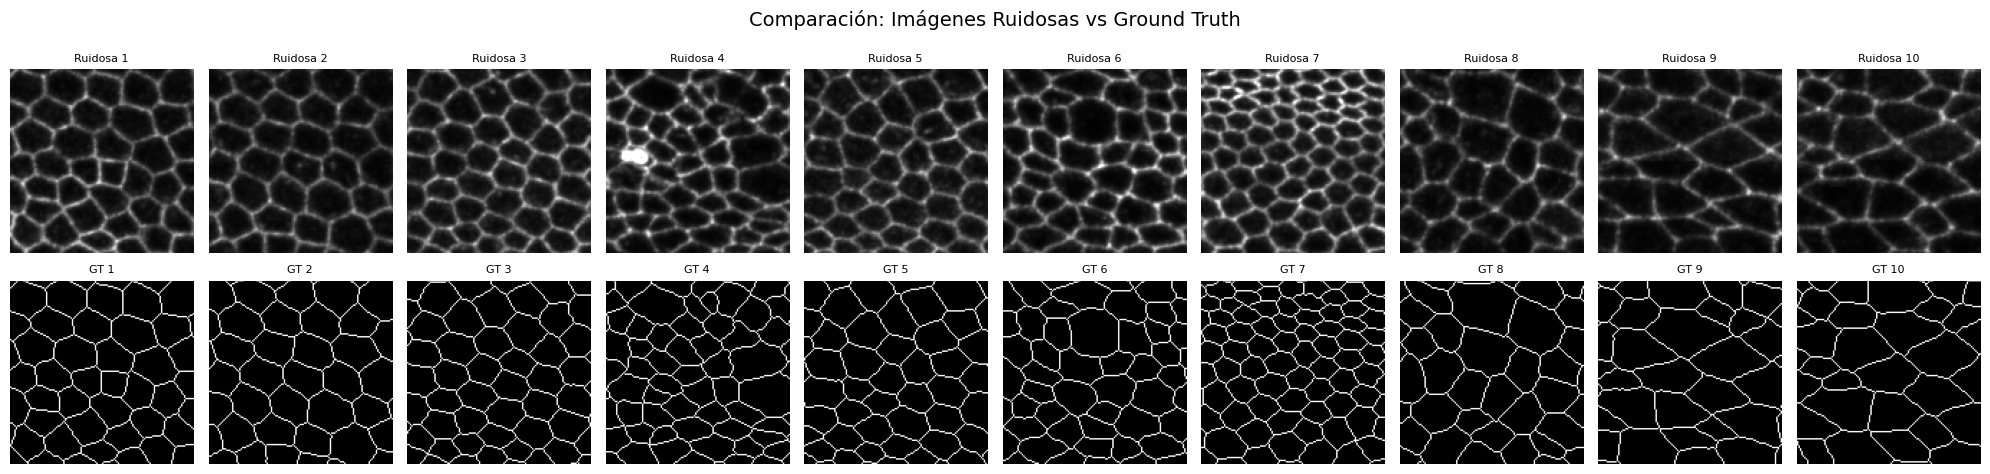

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for i in range(10):
    axes[0, i].imshow(imagenes_con_ruido[i], cmap="gray", vmin=0, vmax=255)
    axes[0, i].set_title(f"Ruidosa {i+1}", fontsize=8)
    axes[0, i].axis("off")

    axes[1, i].imshow(imag_GT[i], cmap="gray", vmin=0, vmax=255)
    axes[1, i].set_title(f"GT {i+1}", fontsize=8)
    axes[1, i].axis("off")

plt.suptitle("Comparación: Imágenes Ruidosas vs Ground Truth", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import cv2
from skimage.metrics import mean_squared_error as mse

# --- Suponiendo que ya tienes una imagen ruidosa y su GT ---
# Ejemplo:
imagen = imagenes_con_ruido[0]
gt = imag_GT[0]

# --- Detectar bordes con Canny ---
canny = cv2.Canny(imagen, 100, 200)  # umbrales ejemplo

# --- Asegurar que GT y predicción estén en el mismo formato ---
gt_bin = (gt > 0).astype(np.uint8) * 255
pred = canny.astype(np.uint8)

# --- Comprobación visual ---
print("Pred shape:", pred.shape, "| GT shape:", gt_bin.shape)
print("Pred range:", pred.min(), "-", pred.max())
print("GT   range:", gt_bin.min(), "-", gt_bin.max())

# --- Calcular RMSE ---
rmse_val = mse(gt_bin, pred) ** 0.5
print("✅ RMSE:", rmse_val)



Pred shape: (128, 128) | GT shape: (128, 128)
Pred range: 0 - 255
GT   range: 0 - 255
✅ RMSE: 115.94120482414446


Aplicación de filtros paso bajo y paso alto

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ipywidgets import interact, IntSlider
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import warnings
warnings.filterwarnings("ignore")

# --- Filtros configurables ---
def aplicar_filtros(imagen, ksize_gauss=5, sigma=1.5, ksize_lap=3):
    imagen = imagen.astype(np.uint8)
    gauss = cv2.GaussianBlur(imagen, (ksize_gauss, ksize_gauss), sigma)
    laplacian = cv2.Laplacian(imagen, cv2.CV_64F, ksize=ksize_lap)
    laplacian = np.clip(laplacian, 0, 255).astype(np.uint8)
    return gauss, laplacian

# --- Visualización con métricas ---
@interact(
    ksize_gauss=IntSlider(5, 3, 11, 2, description="Kernel Gauss"),
    sigma=IntSlider(1, 0, 5, 1, description="Sigma"),
    ksize_lap=IntSlider(3, 1, 7, 2, description="Kernel Lap")
)
def visualizar_filtros_metricas(ksize_gauss=5, sigma=1, ksize_lap=3):
    fig, axes = plt.subplots(10, 3, figsize=(14, 25))

    for i in range(10):
        original = imagenes_con_ruido[i]
        gt = imag_GT[i]
        gauss, laplacian = aplicar_filtros(original, ksize_gauss, sigma, ksize_lap)

        # Calcular métricas
        rmse_g = mse(gt, gauss) ** 0.5
        ssim_g = ssim(gt, gauss, data_range=255)
        rmse_l = mse(gt, laplacian) ** 0.5
        ssim_l = ssim(gt, laplacian, data_range=255)

        # Mostrar original
        axes[i, 0].imshow(original, cmap="gray", vmin=0, vmax=255)
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis("off")

        # Mostrar pasa bajo (gaussiano)
        axes[i, 1].imshow(gauss, cmap="gray", vmin=0, vmax=255)
        axes[i, 1].set_title(f"Gauss\nRMSE: {rmse_g:.1f} | SSIM: {ssim_g:.3f}")
        axes[i, 1].axis("off")

        # Mostrar pasa alto (laplaciano)
        axes[i, 2].imshow(laplacian, cmap="gray", vmin=0, vmax=255)
        axes[i, 2].set_title(f"Laplaciano\nRMSE: {rmse_l:.1f} | SSIM: {ssim_l:.3f}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.suptitle("Filtros Espaciales con Métricas (RMSE / SSIM)", fontsize=16, y=1.02)
    plt.show()



interactive(children=(IntSlider(value=5, description='Kernel Gauss', max=11, min=3, step=2), IntSlider(value=1…

4. Detección de Bordes:

Utilizando técnicas de detección de bordes (como Sobel, Prewitt y Canny), los estudiantes procesarán las imágenes y compararán visualmente los resultados con el ground truth disponible en data['Y_train'].
Las imagnes y GT del dataset puede se obtenidas asi :

trainval_data =  np.load('/content/data/Flywing_n0/train/train_data.npz')

images = trainval_data['X_train']

GT = (trainval_data['Y_train'] < 1).astype(np.int8)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import mean_squared_error as mse, structural_similarity as ssim
from scipy.ndimage import convolve
from ipywidgets import interact, IntSlider

# --- Filtro Prewitt personalizado ---
def prewitt_borde(img):
    kernel_x = np.array([[1, 0, -1],
                         [1, 0, -1],
                         [1, 0, -1]])
    kernel_y = np.array([[1, 1, 1],
                         [0, 0, 0],
                         [-1, -1, -1]])
    gx = convolve(img.astype(float), kernel_x)
    gy = convolve(img.astype(float), kernel_y)
    return np.clip(np.hypot(gx, gy), 0, 255).astype(np.uint8)

# --- Función de visualización con métricas ---
@interact(thresh1=IntSlider(50, 0, 150), thresh2=IntSlider(100, 50, 250))
def comparar_bordes(thresh1=50, thresh2=100):
    fig, axes = plt.subplots(10, 5, figsize=(18, 30))

    for i in range(10):
        noisy = imagenes_con_ruido[i]
        gt = imag_GT[i]

        # Sobel
        sobelx = cv2.Sobel(noisy, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(noisy, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.clip(np.hypot(sobelx, sobely), 0, 255).astype(np.uint8)

        # Prewitt
        prew = prewitt_borde(noisy)

        # Canny
        canny = cv2.Canny(noisy, thresh1, thresh2)

        # Métricas
        def metrics(img_proc):
            return (
                mse(gt, img_proc),
                ssim(gt, img_proc, data_range=255)
            )

        m_sobel, s_sobel = metrics(sobel)
        m_prew, s_prew = metrics(prew)
        m_canny, s_canny = metrics(canny)

        # Mostrar imágenes
        images = [noisy, gt, sobel, prew, canny]
        titles = [
            "Noisy",
            "GT",
            f"Sobel\nRMSE: {m_sobel:.1f}\nSSIM: {s_sobel:.3f}",
            f"Prewitt\nRMSE: {m_prew:.1f}\nSSIM: {s_prew:.3f}",
            f"Canny\nRMSE: {m_canny:.1f}\nSSIM: {s_canny:.3f}"
        ]

        for j in range(5):
            axes[i, j].imshow(images[j], cmap='gray', vmin=0, vmax=255)
            axes[i, j].set_title(titles[j], fontsize=9)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.suptitle("Comparación de Detección de Bordes vs Ground Truth", fontsize=16, y=1.02)
    plt.show()


interactive(children=(IntSlider(value=50, description='thresh1', max=150), IntSlider(value=100, description='t…

5. Descarga del Conjunto de Imágenes de Núcleos Celulares Ruidosos:
Los estudiantes descargarán imágenes de núcleos celulares con ruido desde el siguiente enlace: "http://csbdeep.bioimagecomputing.com/example_data/snr_7_binning_2.zip". Se cargarán las imágenes de la carpeta train/low, que contiene imágenes de núcleos con ruido. Visualizar al menos 10 imágenes seleccionadas aleatoriamente.

In [ ]:
import zipfile
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from PIL import Image

# --- Ruta al archivo ZIP en Google Drive ---
ruta_zip = "/content/drive/MyDrive/Master IA - Notebooks/snr_7_binning_2_parte2.zip"
ruta_extract = "/content/dataset_nucleos"

# --- Descomprimir ZIP si aún no se ha hecho ---
if not os.path.exists(ruta_extract):
    with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
        zip_ref.extractall(ruta_extract)

# --- Directorios con imágenes ruidosas y ground truth ---
dir_ruido = os.path.join(ruta_extract, "train", "low")
dir_gt    = os.path.join(ruta_extract, "train", "GT")

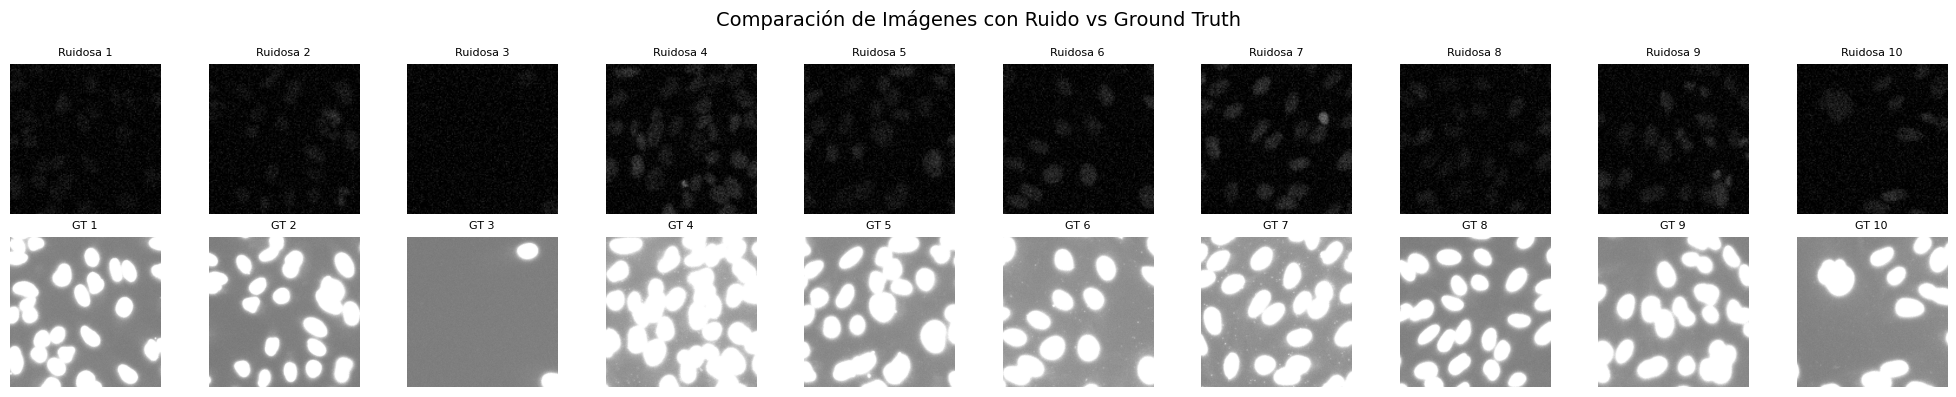

In [ ]:

# --- Leer imágenes ---
imagenes_ruido = sorted([f for f in os.listdir(dir_ruido) if f.lower().endswith(('.tif', '.png', '.jpg'))])
imagenes_gt    = sorted([f for f in os.listdir(dir_gt) if f.lower().endswith(('.tif', '.png', '.jpg'))])

# --- Seleccionar 10 índices aleatorios ---
num_imgs = 10
idxs = random.sample(range(len(imagenes_ruido)), num_imgs)

# --- Cargar imágenes seleccionadas ---
imgs_ruido = []
imgs_gt = []

for i in idxs:
    ruta_r = os.path.join(dir_ruido, imagenes_ruido[i])
    ruta_g = os.path.join(dir_gt, imagenes_gt[i])

    img_r = np.array(Image.open(ruta_r).convert('L'))  # convertimos a escala de grises
    img_g = np.array(Image.open(ruta_g).convert('L'))

    imgs_ruido.append(img_r)
    imgs_gt.append(img_g)

# --- Visualización lado a lado ---
fig, axes = plt.subplots(2, num_imgs, figsize=(20, 4))
for i in range(num_imgs):
    axes[0, i].imshow(imgs_ruido[i], cmap='gray', vmin=0, vmax=255)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Ruidosa {i+1}", fontsize=8)

    axes[1, i].imshow(imgs_gt[i], cmap='gray', vmin=0, vmax=255)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"GT {i+1}", fontsize=8)

plt.suptitle("Comparación de Imágenes con Ruido vs Ground Truth", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def revisar_bits_imagen(imagen):
    """
    Retorna tipo de datos, rango y número de bits por píxel de una imagen.
    """
    dtype = imagen.dtype
    min_val, max_val = imagen.min(), imagen.max()

    # Determinar bits por tipo
    if dtype == np.uint8:
        bits = 8
    elif dtype == np.uint16:
        bits = 16
    elif np.issubdtype(dtype, np.floating):
        bits = 'float'
    else:
        bits = 'desconocido'

    return dtype, (min_val, max_val), bits

# --- Revisión de las 10 imágenes seleccionadas ---
print("🔍 Revisión de Imágenes con Ruido y GT:\n")
for i in range(10):
    img_r = imagenes_con_ruido[i]
    img_gt = imag_GT[i]

    dtype_r, rango_r, bits_r = revisar_bits_imagen(img_r)
    dtype_gt, rango_gt, bits_gt = revisar_bits_imagen(img_gt)

    print(f"🖼 Imagen {i+1}:")
    print(f"  ▸ Ruido: dtype={dtype_r}, rango={rango_r}, bits={bits_r}")
    print(f"  ▸ GT   : dtype={dtype_gt}, rango={rango_gt}, bits={bits_gt}\n")



🔍 Revisión de Imágenes con Ruido y GT:

🖼 Imagen 1:
  ▸ Ruido: dtype=uint8, rango=(np.uint8(3), np.uint8(236)), bits=8
  ▸ GT   : dtype=uint8, rango=(np.uint8(0), np.uint8(255)), bits=8

🖼 Imagen 2:
  ▸ Ruido: dtype=uint8, rango=(np.uint8(4), np.uint8(207)), bits=8
  ▸ GT   : dtype=uint8, rango=(np.uint8(0), np.uint8(255)), bits=8

🖼 Imagen 3:
  ▸ Ruido: dtype=uint8, rango=(np.uint8(5), np.uint8(223)), bits=8
  ▸ GT   : dtype=uint8, rango=(np.uint8(0), np.uint8(255)), bits=8

🖼 Imagen 4:
  ▸ Ruido: dtype=uint8, rango=(np.uint8(2), np.uint8(255)), bits=8
  ▸ GT   : dtype=uint8, rango=(np.uint8(0), np.uint8(255)), bits=8

🖼 Imagen 5:
  ▸ Ruido: dtype=uint8, rango=(np.uint8(5), np.uint8(240)), bits=8
  ▸ GT   : dtype=uint8, rango=(np.uint8(0), np.uint8(255)), bits=8

🖼 Imagen 6:
  ▸ Ruido: dtype=uint8, rango=(np.uint8(1), np.uint8(255)), bits=8
  ▸ GT   : dtype=uint8, rango=(np.uint8(0), np.uint8(255)), bits=8

🖼 Imagen 7:
  ▸ Ruido: dtype=uint8, rango=(np.uint8(5), np.uint8(255)), bits=8

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from ipywidgets import interact, IntSlider

# --- Función de filtro pasa-bajo en frecuencia (FFT) ---
def filtro_pasabajo_fft(imagen, radio=20):
    f = fft2(imagen)
    fshift = fftshift(f)

    filas, cols = imagen.shape
    crow, ccol = filas // 2, cols // 2
    mask = np.zeros_like(imagen, dtype=np.uint8)
    cv2.circle(mask, (ccol, crow), radio, 1, -1)

    fshift_filtrada = fshift * mask
    f_ishift = ifftshift(fshift_filtrada)
    img_filtrada = np.abs(ifft2(f_ishift))
    return np.clip(img_filtrada, 0, 255).astype(np.uint8)

# --- Función para mostrar resultados con métricas ---
@interact(radio=IntSlider(5, 5, 80, 5))
def comparar_fft_con_gt(radio=20):
    num_imgs = len(imgs_ruido)
    fig, axes = plt.subplots(num_imgs, 3, figsize=(13, 3 * num_imgs))

    for i in range(num_imgs):
        noisy = imgs_ruido[i]
        gt = imgs_gt[i]
        filtrada = filtro_pasabajo_fft(noisy, radio=radio)

        # Métricas
        rmse_val = mse(gt, filtrada) ** 0.5
        ssim_val = ssim(gt, filtrada, data_range=255)

        # Mostrar
        axes[i, 0].imshow(noisy, cmap='gray', vmin=0, vmax=255)
        axes[i, 0].set_title(f"🔧 Ruidosa {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(filtrada, cmap='gray', vmin=0, vmax=255)
        axes[i, 1].set_title(f"🌀 FFT (radio={radio})\nRMSE: {rmse_val:.1f} | SSIM: {ssim_val:.3f}")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(gt, cmap='gray', vmin=0, vmax=255)
        axes[i, 2].set_title(f"✅ GT {i+1}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.suptitle("Comparación: FFT Pasa-Bajo vs Ground Truth", fontsize=16, y=1.02)
    plt.show()


interactive(children=(IntSlider(value=5, description='radio', max=80, min=5, step=5), Output()), _dom_classes=…

In [ ]:
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import seaborn as sns
import pandas as pd

# --- Inicializar listas de resultados ---
resultados = {
    'Imagen': [],
    'Filtro': [],
    'RMSE': [],
    'SSIM': []
}

# --- Funciones de filtros ---
def filtro_gauss(img):
    return cv2.GaussianBlur(img, (5,5), 1.5)

def filtro_mediana(img):
    return cv2.medianBlur(img, 5)

def filtro_fft(img, radio=20):
    f = fft2(img)
    fshift = fftshift(f)
    filas, cols = img.shape
    crow, ccol = filas // 2, cols // 2
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.circle(mask, (ccol, crow), radio, 1, -1)
    filtrada = np.abs(ifft2(ifftshift(fshift * mask)))
    return np.clip(filtrada, 0, 255).astype(np.uint8)

# --- Evaluar todas las imágenes ---
for i in range(len(imgs_ruido)):
    img_r = imgs_ruido[i]
    img_gt = imgs_gt[i]

    for nombre, func in {
        "Gauss": filtro_gauss,
        "Mediana": filtro_mediana,
        "FFT": filtro_fft
    }.items():
        img_filt = func(img_r)

        # Calcular métricas
        val_rmse = mse(img_gt, img_filt) ** 0.5
        val_ssim = ssim(img_gt, img_filt, data_range=255)

        # Guardar resultados
        resultados['Imagen'].append(f"img_{i+1}")
        resultados['Filtro'].append(nombre)
        resultados['RMSE'].append(val_rmse)
        resultados['SSIM'].append(val_ssim)


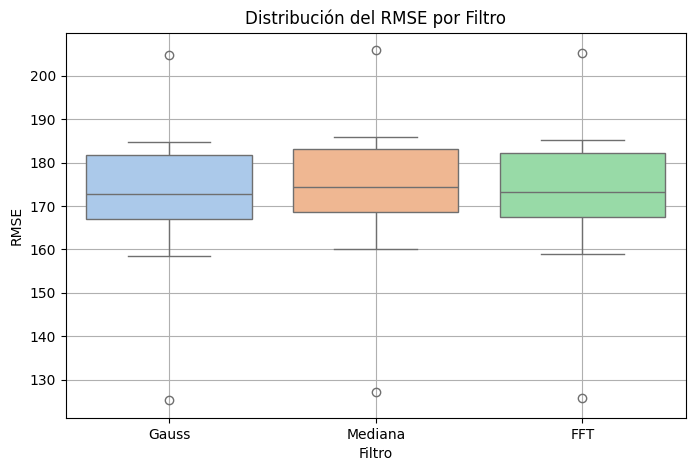

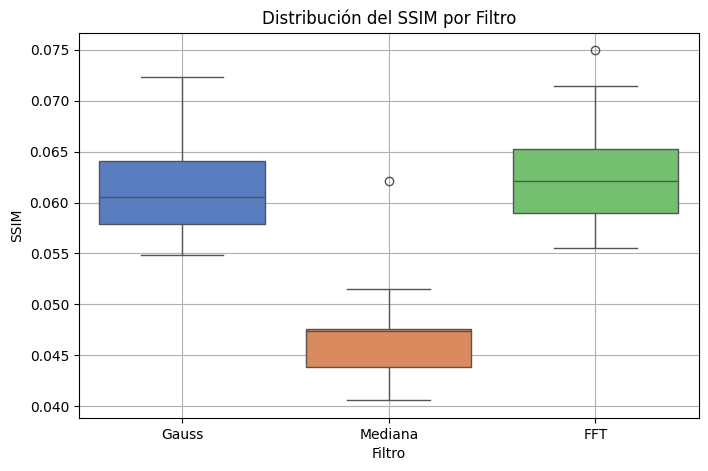

In [ ]:
# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Boxplot RMSE
plt.figure(figsize=(8,5))
sns.boxplot(data=df_resultados, x="Filtro", y="RMSE", palette="pastel")
plt.title("Distribución del RMSE por Filtro")
plt.grid(True)
plt.show()

# Boxplot SSIM
plt.figure(figsize=(8,5))
sns.boxplot(data=df_resultados, x="Filtro", y="SSIM", palette="muted")
plt.title("Distribución del SSIM por Filtro")
plt.grid(True)
plt.show()
